# 信用评分模型开发

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
from xgboost import XGBClassifier

import seaborn as sns
sns.set(style = "darkgrid")

import warnings
warnings = warnings.filterwarnings("ignore")

In [13]:
#载入数据
path = 'M:/Project_Datasets/GiveMeSomeCredit/'
data = pd.read_csv(path + 'train.csv')
data=data.iloc[:,1:]
print(data.shape)
data.head()

(150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

## EDA and Preprocessing

In [15]:
# 描述性统计
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64
0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64
------------------------------------------


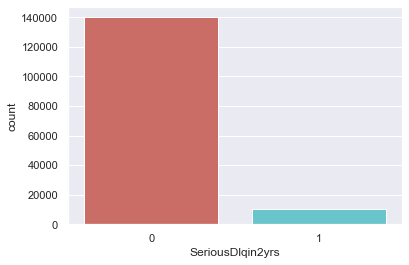

In [16]:
# 查看目标变量SeriousDlqin2yrs的数据分布
print(data['SeriousDlqin2yrs'].value_counts())
print(data['SeriousDlqin2yrs'].value_counts()/len(data))
print('---' * 14)
sns.countplot(x = 'SeriousDlqin2yrs',data = data, palette = 'hls')
plt.show()

In [17]:
# 一般而言，违约客户为0，正常履约客户为1。所以将目标变量SeriousDlqin2yrs的值取反
data['SeriousDlqin2yrs']=1-data['SeriousDlqin2yrs']

In [18]:
# 查看缺失值
data.isnull().sum()/len(data)

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

MonthlyIncome列缺失19.82%的数据、NumberOfDependents列缺失2.62%的数据

In [19]:
# 采用随机森林算法填充MonthlyIncome的缺失值
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

def set_missing(df):
    process_df = df.iloc[:, [5,0,1,2,3,4,6,7,8,9]] 
    known = process_df[process_df.MonthlyIncome.notnull()].values
    unknown = process_df[process_df.MonthlyIncome.isnull()].values
    X = known[:, 1:]
    y = known[:, 0]
    rfr = RandomForestRegressor(n_estimators=200, 
                                max_depth=3, 
                                n_jobs=-1, 
                                random_state=0)
    rfr.fit(X,y)
    predicted = rfr.predict(unknown[:, 1:]).round(0)
    print(predicted)
    df.loc[df.MonthlyIncome.isnull(), 'MonthlyIncome'] = predicted
    return df

data = set_missing(data)

[8311. 1159. 8311. ... 1159. 2554. 2554.]


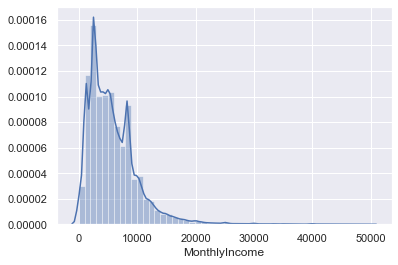

In [20]:
income = data[data['MonthlyIncome']<50000]['MonthlyIncome'] 
sns.distplot(income)

In [21]:
# 删除NumberOfDependents的缺失值
data = data.dropna()
# 删除重复项
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145563 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      145563 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  145563 non-null  float64
 2   age                                   145563 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  145563 non-null  int64  
 4   DebtRatio                             145563 non-null  float64
 5   MonthlyIncome                         145563 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       145563 non-null  int64  
 7   NumberOfTimes90DaysLate               145563 non-null  int64  
 8   NumberRealEstateLoansOrLines          145563 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  145563 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

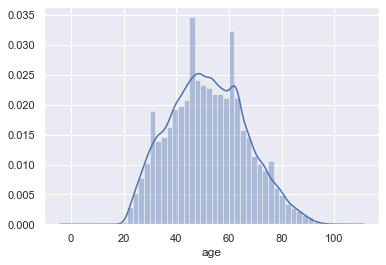

In [22]:
# 观察age数据分布
age = data['age']
sns.distplot(age)

In [23]:
# 特征变量age的数据分布图发现age中存在0，显然为异常值，直接剔除
data=data[data['age']>0]

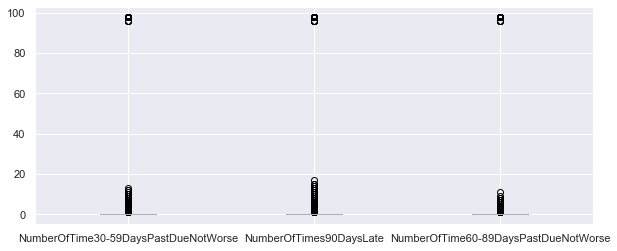

In [24]:
'''
NumberOfTime30-59DaysPastDueNotWorse,
NumberOfTimes90DaysLate,
NumberOfTime60-89DaysPastDueNotWorse
'''
train_box = data.iloc[:,[3,7,9]]
train_box.boxplot(figsize=(10,4))

In [25]:
print(data["NumberOfTime30-59DaysPastDueNotWorse"].unique())
print(data["NumberOfTimes90DaysLate"].unique())
print(data["NumberOfTime60-89DaysPastDueNotWorse"].unique())

[ 2  0  1  3  4  5  7 10  6 98 12  8  9 96 13 11]
[ 0  1  3  2  5  4 98 10  9  6  7  8 15 96 11 13 14 17 12]
[ 0  1  2  5  3 98  4  6  7  8 96 11  9]


In [26]:
# 剔除这3个特征变量的异常值
data = data[data['NumberOfTime30-59DaysPastDueNotWorse'] < 90]
data = data[data['NumberOfTimes90DaysLate'] < 90]
data = data[data['NumberOfTime60-89DaysPastDueNotWorse'] < 90]

## 划分训练集和测试集

In [27]:
X = data.drop(['SeriousDlqin2yrs'], axis = 1)
y = data['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2020)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
#clasTest = testDf.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count()

## WOE分箱

In [28]:
def mono_bin(X, y, n):
    r = 0
    good = y.sum()
    bad = y.count() - good
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X" : X, "y" : y, "Bucket" : pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().y
    d3['total'] = d2.count().y
    d3['rate'] = d2.mean().y
    d3['woe'] = np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['goodattribute'] = d3['sum']/good
    d3['badattribute'] = (d3['total']-d3['sum'])/bad
    iv = ((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_index(kind = 'min'))
    woe = list(d4['woe'].round(3))
    
    cut=[]
    cut.append(float('-inf')) 
    for i in range(1, n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,4))
    cut.append(float('inf'))
    
    return d4, iv, cut, woe

In [29]:
dfx1, ivx1, cutx1, woex1 = mono_bin(train_df.RevolvingUtilizationOfUnsecuredLines, 
                                    train_df.SeriousDlqin2yrs, 
                                    n=10)

dfx2, ivx2, cutx2, woex2 = mono_bin(train_df.age, 
                                    train_df.SeriousDlqin2yrs, 
                                    n=10)

dfx4, ivx4, cutx4, woex4 = mono_bin(train_df.DebtRatio, 
                                    train_df.SeriousDlqin2yrs, 
                                    n=20)

dfx5, ivx5, cutx5, woex5 = mono_bin(train_df.MonthlyIncome, 
                                    train_df.SeriousDlqin2yrs, 
                                    n=10)

对于上述分箱方法不能合理拆分的特征，采用无监督分箱的手动分箱：

In [30]:
pinf = float('inf')
ninf = float('-inf')
cutx3 = [ninf, 0, 1, 3, 5, pinf]
cutx6 = [ninf, 1, 2, 3, 5, 7, 9, pinf]
cutx7 = [ninf, 0, 1, 3, 5, pinf]
cutx8 = [ninf, 0,1,2, 3, pinf]
cutx9 = [ninf, 0, 1, 3, pinf]
cutx10 = [ninf, 0, 1, 2, 3, 5, pinf]

# 自定义人工分箱函数
def self_bin(X, y, cat):   
    good = y.sum()
    bad = y.count()-good
    d1 = pd.DataFrame({'X' : X,'y' : y,'Bucket' : pd.cut(X,cat)})
    d2 = d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().y
    d3['total'] = d2.count().y
    d3['rate'] = d2.mean().y
    d3['woe'] = np.log((d3['rate']/(1-d3['rate']))/(good/bad))   
    d3['goodattribute'] = d3['sum']/good
    d3['badattribute'] = (d3['total']-d3['sum'])/bad
    iv = ((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_index(kind = 'min'))
    woe = list(d4['woe'].round(3))
    return d4, iv, woe

In [31]:
dfx3, ivx3, woex3 = self_bin(train_df['NumberOfTime30-59DaysPastDueNotWorse'], 
                             train_df.SeriousDlqin2yrs, 
                             cutx3)

dfx6, ivx6, woex6= self_bin(train_df['NumberOfOpenCreditLinesAndLoans'], 
                            train_df.SeriousDlqin2yrs, 
                            cutx6)

dfx7, ivx7, woex7 = self_bin(train_df['NumberOfTimes90DaysLate'], 
                             train_df.SeriousDlqin2yrs, 
                             cutx7)

dfx8, ivx8, woex8 = self_bin(train_df['NumberRealEstateLoansOrLines'], 
                             train_df.SeriousDlqin2yrs, 
                             cutx8)

dfx9, ivx9, woex9 = self_bin(train_df['NumberOfTime60-89DaysPastDueNotWorse'], 
                             train_df.SeriousDlqin2yrs, 
                             cutx9)

dfx10, ivx10, woex10 = self_bin(train_df['NumberOfDependents'], 
                                train_df.SeriousDlqin2yrs, 
                                cutx10)

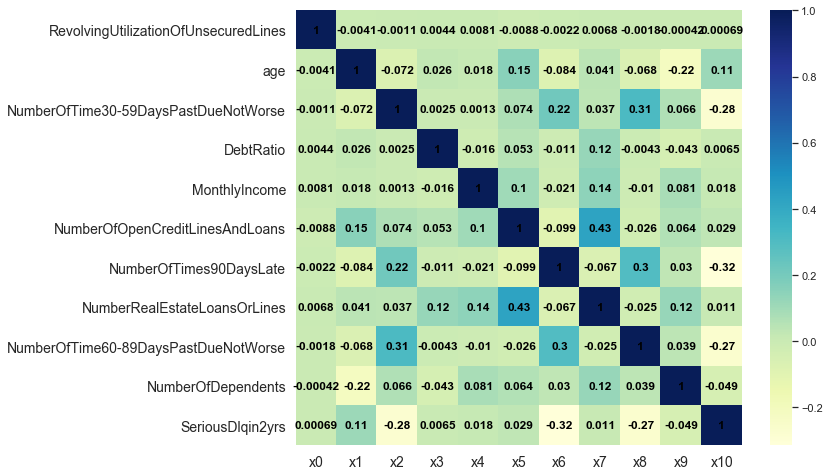

In [32]:
# 相关性分析，判断复共线性严重程度
corr = train_df.corr()
xticks = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 
          'x6', 'x7', 'x8', 'x9', 'x10']
yticks = list(corr.index)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, annot = True, cmap = 'YlGnBu',
            annot_kws = {'size' : 12, 
                         'weight' : 'bold', 
                         'color' : 'black'})
ax.set_xticklabels(xticks, rotation=0, fontsize=14)
ax.set_yticklabels(yticks, rotation=0, fontsize=14)
plt.show()

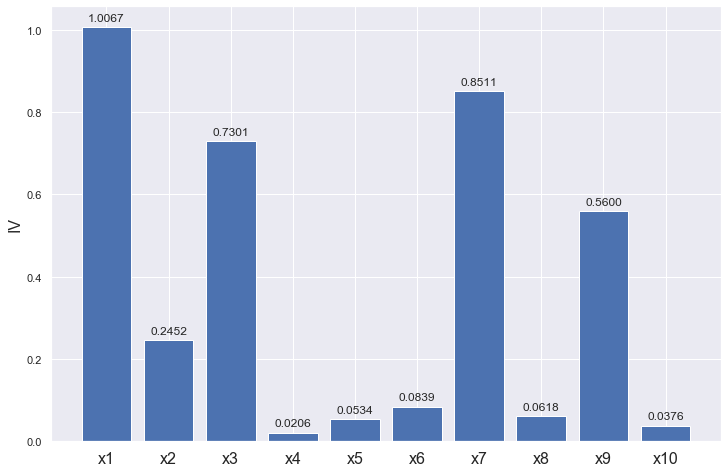

In [33]:
ivlist = [ivx1, ivx2, ivx3, ivx4, ivx5, 
          ivx6, ivx7, ivx8, ivx9, ivx10]
index = ['x1', 'x2', 'x3', 'x4', 'x5', 
         'x6', 'x7', 'x8', 'x9', 'x10']
fig, ax = plt.subplots(figsize=(12,8))
x = np.arange(len(index)) + 1
ax.bar(x, ivlist, width=.8)
ax.set_xticks(x)
ax.set_xticklabels(index, rotation=0, fontsize=16)
ax.set_ylabel('IV', fontsize=16)
for a, b in zip(x, ivlist):
    plt.text(a, b + 0.01, '%.4f' % b, 
             ha='center', va='bottom', fontsize=12)
plt.show()

一般而言，IV值在0.02以下不具有有效信息。x2、x4、x5、x6、x8、x10的IV值在0.02-0.5之间，具有有效信息。x1、x3、x7、x9的IV值在0.5以上，包含大量有效信息，可参与模型训练，也可单独作为规则使用。

In [34]:
# 建模前需将筛选后的变量转换为WOE值，便于信用评分
def transform_woe(var, var_name, woe, cut):
    woe_name = var_name + '_woe'
    for i in range(len(woe)):
        if i == 0:
            var.loc[(var[var_name]<=cut[i+1]), woe_name]=woe[i]
        elif (i>0) and (i<=len(woe)-2):
            var.loc[((var[var_name]>cut[i])&(var[var_name]<=cut[i+1])), woe_name]=woe[i] 
        else:
            var.loc[(var[var_name]>cut[len(woe)-1]), woe_name]=woe[len(woe)-1]  
    return var

In [35]:
x1 = 'RevolvingUtilizationOfUnsecuredLines'
x2 = 'age'
x3 = 'NumberOfTime30-59DaysPastDueNotWorse'
x4 = 'DebtRatio'
x5 = 'MonthlyIncome'
x6 = 'NumberOfOpenCreditLinesAndLoans'
x7 = 'NumberOfTimes90DaysLate'
x8 = 'NumberRealEstateLoansOrLines'
x9 = 'NumberOfTime60-89DaysPastDueNotWorse'
x10 = 'NumberOfDependents'

train_df = transform_woe(train_df, x1, woex1, cutx1)
train_df = transform_woe(train_df, x2, woex2, cutx2)
train_df = transform_woe(train_df, x3, woex3, cutx3)
train_df = transform_woe(train_df, x4, woex4, cutx4)
train_df = transform_woe(train_df, x5, woex5, cutx5)
train_df = transform_woe(train_df, x6, woex6, cutx6)
train_df = transform_woe(train_df, x7, woex7, cutx7)
train_df = transform_woe(train_df, x8, woex8, cutx8)
train_df = transform_woe(train_df, x9, woex9, cutx9)
train_df = transform_woe(train_df, x10, woex10, cutx10)

In [36]:
# 目标变量
y = train_df['SeriousDlqin2yrs']

# 选取相应的特征变量
X = train_df.drop(['SeriousDlqin2yrs'], axis = 1)
X = train_df.iloc[:, 11:]
X.head()

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,NumberOfDependents_woe
86274,0.314,-0.285,0.534,0.083,0.361,0.064,0.377,0.184,0.274,-0.206
50496,-1.111,-0.548,-0.913,-0.189,-0.186,-0.392,0.377,-0.250,-2.681,0.161
392,0.314,1.096,0.534,0.083,0.361,0.064,0.377,-0.250,0.274,0.161
97892,-1.111,0.225,-1.760,0.083,0.361,0.025,0.377,0.184,0.274,0.161
91907,-1.111,-0.548,-0.913,0.083,-0.102,0.239,0.377,0.257,0.274,-0.101


In [37]:
test_df = transform_woe(test_df, x1, woex1, cutx1)
test_df = transform_woe(test_df, x2, woex2, cutx2)
test_df = transform_woe(test_df, x3, woex3, cutx3)
test_df = transform_woe(test_df, x4, woex4, cutx4)
test_df = transform_woe(test_df, x5, woex5, cutx5)
test_df = transform_woe(test_df, x6, woex6, cutx6)
test_df = transform_woe(test_df, x7, woex7, cutx7)
test_df = transform_woe(test_df, x8, woex8, cutx8)
test_df = transform_woe(test_df, x9, woex9, cutx9)
test_df = transform_woe(test_df, x10, woex10, cutx10)

test_y = test_df['SeriousDlqin2yrs']
test_X = test_df.drop(['SeriousDlqin2yrs'], axis = 1)
test_X = test_df.iloc[:, 11:]
test_X.head()

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,NumberOfDependents_woe
2709,1.328,-0.548,0.534,-0.189,-0.102,0.239,0.377,0.184,0.274,-0.101
137052,0.314,0.940,0.534,0.083,0.361,0.064,0.377,0.184,0.274,0.161
125061,1.328,-0.066,0.534,0.083,-0.186,-0.178,0.377,0.257,0.274,-0.101
89763,1.238,1.096,0.534,-0.189,-0.186,0.168,0.377,0.257,0.274,-0.101
50712,1.238,0.940,0.534,0.083,-0.102,0.168,0.377,0.257,0.274,0.161


## 贝叶斯调参优化

In [38]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [39]:
def xgb_cv(learning_rate, n_estimators, max_depth):
    val = cross_val_score(XGBClassifier(
        learning_rate = min(learning_rate, 0.99), 
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        random_state=2020),
                          X, y, scoring='roc_auc', cv=5).mean()
    return val

In [40]:
xgb_bo = BayesianOptimization(xgb_cv, 
                              {'learning_rate':(0.01, 0.99),
                               'n_estimators':(100, 500), 
                               'max_depth':(2, 10)})
xgb_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.8581   |  0.6189   |  2.68     |  235.7    |
|  2        |  0.759    |  0.8602   |  7.86     |  444.5    |
|  3        |  0.7425   |  0.8328   |  9.791    |  393.2    |
|  4        |  0.836    |  0.941    |  4.633    |  307.4    |
|  5        |  0.8552   |  0.1212   |  5.363    |  253.1    |
|  6        |  0.8514   |  0.01     |  10.0     |  100.0    |
|  7        |  0.8576   |  0.5954   |  2.375    |  499.9    |
|  8        |  0.8577   |  0.07278  |  2.84     |  232.4    |
|  9        |  0.7666   |  0.7876   |  9.932    |  162.8    |
|  10       |  0.8576   |  0.9625   |  2.077    |  101.0    |
|  11       |  0.7712   |  0.3332   |  9.858    |  499.7    |
|  12       |  0.8564   |  0.04019  |  2.021    |  273.8    |
|  13       |  0.8549   |  0.02337  |  2.26     |  343.1    |
|  14       |  0.8586   |  0.2222   |  2.057    |  481.3    |
|  15   

In [41]:
xgb_bo.max

{'target': 0.858754936650751,
 'params': {'learning_rate': 0.2673407860795405,
  'max_depth': 2.0663029107802258,
  'n_estimators': 250.1334449879121}}

## 拟合模型

In [48]:
def xgb_model(X, y, test_X, test_y):  
    xgb = XGBClassifier(
        learning_rate=0.3, 
        n_estimators=299,  
        max_depth=2, 
        class_weight='balanced',  
        min_child_weight=1,  
        subsample=1,   
        nthread=-1,  
        scale_pos_weight=1,  
        random_state=2020,  
        n_jobs=-1,  
        reg_lambda=300        
    )
    xgb.fit(X, y)
    y_pred = xgb.predict_proba(X)[:,1]  
    fpr_tr, tpr_tr, _ = roc_curve(y, y_pred)
    train_roc_auc = auc(fpr_tr, tpr_tr)
    train_ks = abs(fpr_tr-tpr_tr).max()
    print('train auc score: {0:.4f}'.format(train_roc_auc))
    print('train ks: {0:.4f}'.format(train_ks))
    print('--' * 12)
    y_test_pred = xgb.predict_proba(test_X)[:,1]
    fpr_ts, tpr_ts, _ = roc_curve(test_y, y_test_pred)
    test_roc_auc = auc(fpr_ts, tpr_ts)
    test_ks = abs(fpr_ts-tpr_ts).max()
    print('test auc score: {0:.4f}'.format(test_roc_auc))
    print('test ks: {0:.4f}'.format(test_ks))

    plt.figure(figsize = (10, 7))
    plt.plot(fpr_tr, tpr_tr, label = 'train')
    plt.plot(fpr_ts, tpr_ts, label = 'test')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

train auc score: 0.8603
train ks: 0.5643
------------------------
test auc score: 0.8556
test ks: 0.5586


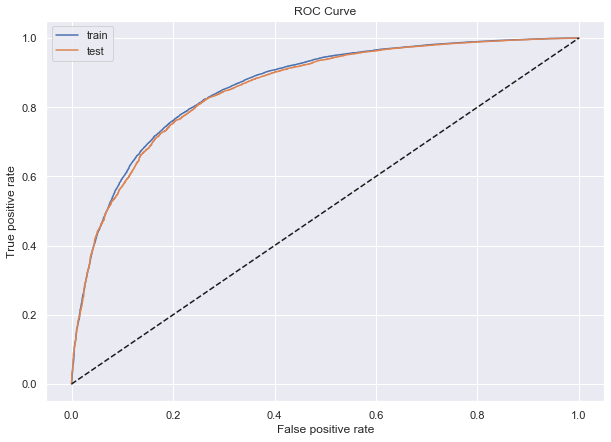

In [49]:
xgb_model(X, y, test_X, test_y)

## 计算AUC值和KS值

In [47]:
from toad.metrics import AUC, KS

xgb = XGBClassifier(
        learning_rate=0.3, 
        n_estimators=299,  
        max_depth=2,  
        class_weight='balanced',  
        min_child_weight=1,  
        subsample=1,   
        nthread=-1,  
        scale_pos_weight=1,  
        reg_lambda=300, 
        random_state=2020, 
        n_jobs=-1
)
xgb.fit(X, y) 
y_pred = xgb.predict_proba(X)[:,1]
y_test_pred = xgb.predict_proba(test_X)[:,1]

print('训练集：')
print('AUC: {0:.4f}'.format(AUC(y_pred, y)))
print('KS: {0:.4f}'.format(KS(y_pred, y)))
print("-" * 11)
print('测试集：')
print('AUC: {0:.4f}'.format(AUC(y_test_pred, test_y)))
print('KS: {0:.4f}'.format(KS(y_test_pred, test_y)))

训练集：
AUC: 0.8603
KS: 0.5643
-----------
测试集：
AUC: 0.8556
KS: 0.5586
